# tax AI agent

## 기본 세팅

In [153]:
from dotenv import load_dotenv

load_dotenv()

True

In [154]:
# from langchain_community.document_loaders import Docx2txtLoader
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size = 1500,
#     chunk_overlap = 200,
# )

# loader = Docx2txtLoader('./data/tax.docx')
# temp = loader.load_and_split(text_splitter=text_splitter)

# document_list = temp[0:80]
# len(document_list)

In [155]:
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [156]:
from langchain_chroma import Chroma

# 처음 생성할때만
# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding,
#     collection_name='chroma_tax',
#     persist_directory='./chroma_tax'
# )

# 불러오기
vector_store = Chroma(
    embedding_function=embedding,
    collection_name='chroma_tax',
    persist_directory='./chroma_tax'   
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [157]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query : str
    context : List[Document]
    answer : str
    is_generate : bool
    generation : int

## 코드 작성(실패)

In [158]:
system_prompt = """
당신은 주어진 맥락(Context)이 질문(Query)에 답변하기에 충분히 관련성이 있는지 판단하는 AI입니다.

QUESTION = {{question}}
CONTEXT = {{documents}}

판단 기준:
- Context에 Query의 핵심 키워드 또는 의미적으로 관련된 내용이 포함되어 있으면 "generate"를 반환하세요.
- Context와 Query가 완전히 무관하거나, Context가 너무 모호하여 답변을 생성할 수 없다면 "rewrite"를 반환하세요.

당신의 응답은 오직 "generate" 또는 "rewrite" 두 단어 중 하나여야 하며, 다른 어떠한 설명도 포함하지 마세요.
"""

In [159]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [160]:
# retrieve 노드
# 유사도가 높은 문서를 뽑고 그것을 유사성 점수 검사를 함
# 유사도가 높지 않으면 query를 다시 작성하는 rewrite로 보내기
# 유사도가 높으면 그것을 기반으로 답변을 작성하는 generate로 보내기

from langchain_core.prompts import PromptTemplate

def retrieve(state: AgentState) -> AgentState:
    query = state['query']

    print(query)

    docs = retriever.invoke(query)

    context = [doc.page_content for doc in docs]

    # PromptTemplate 객체 생성
    prompt = PromptTemplate.from_template(system_prompt)

    # # 변수에 값을 할당하여 템플릿을 완성합니다.
    # formatted_prompt = prompt.format(
    #     question=query,
    #     documents=documents
    # )

    llm_chain = prompt | llm

    response = llm_chain.invoke({"question" : query, "documents" : context})

    print(f"is_generate : {response.content}")

    return {"context" : docs, "is_generate" : True if response.content.strip().lower() == "generate" else False, "generation" : state["generation"]+1}


In [161]:

def rewrite(state: AgentState) -> AgentState:
    rewrite_prompt = """
    현재의 Query와 Context는 서로 관련성이 부족합니다.

    Query의 핵심 의도는 유지하되, Context의 내용을 활용하여 Query를 더 포괄적이고 다양한 검색 결과를 가져올 수 있는 형태로 수정하세요. Context가 너무 무관하다면, 기존 Query를 그대로 유지하거나 용어만 조금 변경하여 반환하세요.

    응답은 오직, 수정된 새로운 Query의 내용만을 반환해야 합니다. 다른 설명, 사과문, 또는 추가적인 요소는 절대 포함하지 마세요.

    Query: {{query}}
    Context: {{context}}
    """
    docs = state["context"]
    context = [doc.page_content for doc in docs]

    print("old query", state["query"])
    # print("context", context)

    # PromptTemplate 객체 생성
    prompt = PromptTemplate.from_template(rewrite_prompt)

    llm_chain = prompt | llm

    response = llm_chain.invoke({"query" : state["query"], "context" : context})

    print(f"new qeury : {response.content}")
    return {"query" : response.content}

In [162]:
def generate(state: AgentState) -> AgentState:
    generate_prompt = """ 
    너는 대한민국 세법 전문가이다. 다음 사용자의 Query와 Context를 기반으로 정확하고 유용한 답변을 제공하라.

    Query = {{query}}
    Context = {{context}}

    답변의 내용은 Context에 '몇 조 몇 항' 과 같은 어디서 참조했는지를 알 수 있는 자료가 있다면 답변에 반드시 포함하라.
    최대한 Context의 내용을 기반으로 답변을 작성하라.
    """

    # PromptTemplate 객체 생성
    prompt = PromptTemplate.from_template(generate_prompt)

    llm_chain = prompt | llm

    response = llm_chain.invoke({"query" : state["query"], "context" : state["context"]})

    return {"answer" : response.content}

In [163]:
from typing import Literal

def should_generate(state: AgentState) -> Literal["generate", "rewrite"]:
    if state["generation"] > 3:
        return "generate"
    if state["is_generate"]:
        return "generate"
    else:
        return "rewrite"

In [164]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

builder.add_node("retrieve", retrieve)
builder.add_node("rewrite", rewrite)
builder.add_node("generate", generate)

builder.add_edge(START, "retrieve")
builder.add_conditional_edges(
    "retrieve",
    should_generate,
    {
        "generate" : "generate",
        "rewrite" : "rewrite"
    }
)
builder.add_edge("rewrite", "retrieve")
builder.add_edge("generate", END)

graph = builder.compile()

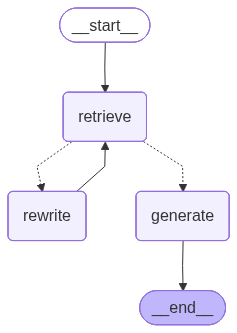

In [165]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {
    "query" : "연봉 5000만원 직장인의 소득세는 얼마인가?",
    "generation" : 1
}

response = graph.invoke(inputs)

print(response.content)

## 교수님 코드

In [169]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query : str
    context : List[Document]
    answer : str

In [170]:
def retrieve(state:AgentState) -> AgentState:
    """ 
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.
    Args : 
        state (AgentState) : 사용자의 질문을 포함한 에이전트의 현재 state
    Returns : 
        AgentState: 검색한 문서가 추가된 state를 반환합니다.
    """

    query = state['query']
    docs = retriever.invoke(query)

    return {"context" : docs}
    

In [171]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")


In [ ]:
from langchain import hub

generate_prompt = hub.pull('rlm/rag-prompt')

def generate(state: AgentState) -> AgentState:
    """ 
    주어진 state를 기반하여 RAG 체인을 사용하여 응답을 생성합니다.
    Args : 
        state (AgentState) : 사용자의 질문과 문맥을 포함하는 state
    Returns : 
        AgentState: 최종 생성된 응답을 포함하는 state 반환
    """

    context = state['context'] #이렇게 바로 넣어줘도 되나? List[Document]를? 그럼 알아서 문자열로 들어간다고?
    query = state['query']

    rag_chain = generate_prompt | llm
    resonse = rag_chain.invoke({"question" : query, "context" : context})

    return {"answer" : response}

In [172]:
from langchain import hub
from typing import Literal

doc_relevence_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevence(state : AgentState) -> Literal['generate', 'rewrite']:
    """ 
    주어진 state를 기반하여 문서의 관련성을 판단합니다.
    Args : 
        state (AgentState) : 사용자의 질문과 문맥을 포함하는 state
    Returns : 
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
    """

    query = state["query"]
    context = state["context"]

    doc_relevence_chain = doc_relevence_prompt | llm

    response = doc_relevence_chain.invoke({"question" : query, "documents" : context})

    if response['Score'] == 1:
        return "generate"
    
    return "rewrite"

c:\git_repo\GJ_class\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [173]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리 사전을 참고해서 사용자의 질문을 변경해 주세요.
사전 : {dictionary}
질문 : {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """ 
    사용자의 질문을 사전을 고려하여 변경합니다.
    Args : 
        state (AgentState) : 사용자의 질문을 포함하는 state
    Returns : 
        AgentState : 변경된 질문을 포함하는 state를 반환합니다.
    """

    query = state['query']

    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({"query" : query})

    return {"query" : response}



In [174]:
builder = StateGraph(AgentState)

builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)
builder.add_node("rewrite", rewrite)

builder.add_edge(START, 'retrieve')
builder.add_conditional_edges(
    "retrieve",
    check_doc_relevence # 노드 이름을 리턴한다면, 추가로 작성해 줄 필요 없다.
)
builder.add_edge("rewrite", "retrieve")
builder.add_edge("generate", END)


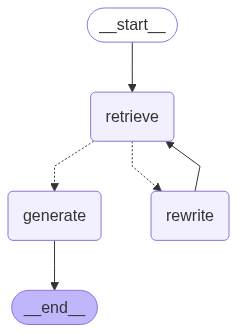

In [175]:
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [176]:
initial_state = {"query" : "연봉 5000만원 직장인의 소득세는?"}

response = graph.invoke(initial_state)

In [177]:
response

{'query': '연봉 5000만원 직장인의 소득세는?',
 'context': [Document(metadata={'source': './data/tax.docx'}, page_content='차. 외국정부(외국의 지방자치단체와 연방국가인 외국의 지방정부를 포함한다. 이하 같다) 또는 대통령령으로 정하는 국제기관에서 근무하는 사람으로서 대통령령으로 정하는 사람이 받는 급여. 다만, 그 외국정부가 그 나라에서 근무하는 우리나라 공무원의 급여에 대하여 소득세를 과세하지 아니하는 경우만 해당한다.\n\n카. 「국가유공자 등 예우 및 지원에 관한 법률」 또는 「보훈보상대상자 지원에 관한 법률」에 따라 받는 보훈급여금ㆍ학습보조비\n\n타. 「전직대통령 예우에 관한 법률」에 따라 받는 연금\n\n파. 작전임무를 수행하기 위하여 외국에 주둔 중인 군인ㆍ군무원이 받는 급여\n\n하. 종군한 군인ㆍ군무원이 전사(전상으로 인한 사망을 포함한다. 이하 같다)한 경우 그 전사한 날이 속하는 과세기간의 급여\n\n거. 국외 또는 「남북교류협력에 관한 법률」에 따른 북한지역에서 근로를 제공하고 받는 대통령령으로 정하는 급여\n\n너. 「국민건강보험법」, 「고용보험법」 또는 「노인장기요양보험법」에 따라 국가, 지방자치단체 또는 사용자가 부담하는 보험료\n\n더. 생산직 및 그 관련 직에 종사하는 근로자로서 급여 수준 및 직종 등을 고려하여 대통령령으로 정하는 근로자가 대통령령으로 정하는 연장근로ㆍ야간근로 또는 휴일근로를 하여 받는 급여\n\n러. 근로자가 사내급식이나 이와 유사한 방법으로 제공받는 식사 기타 음식물 또는 근로자(식사 기타 음식물을 제공받지 아니하는 자에 한정한다)가 받는 월 20만원 이하의 식사대\n\n머. 근로자 또는 그 배우자의 출산이나 6세 이하(해당 과세기간 개시일을 기준으로 판단한다) 자녀의 보육과 관련하여 사용자로부터 받는 급여로서 월 20만원 이내의 금액\n\n버. 「국군포로의 송환 및 대우 등에 관한 법률」에 따른 국군포로가 받는 보수 및 퇴직일시금\n

In [179]:
print(response['answer'])

물론입니다. Query와 Context를 제공해 주시면 그에 맞춰 답변을 드리겠습니다.
